# Business Analysis of Movie Data
### By: Christian Tsui


## Import Packages

In [228]:
# Your code here - remember to use markdown cells for comments as well!
# Connecting to the Database
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
%matplotlib inline


## Load & Preview Dataset

In [229]:
gross_csv = "./zippedData/bom.movie_gross.csv.gz"
imdb_zip = "./zippedData/im.db"
info_tsv = "./zippedData/rt.movie_info.tsv.gz"
reviews_tsv = "./zippedData/rt.reviews.tsv.gz"
tmdb_csv = "./zippedData/tmdb.movies.csv.gz"
budgets_csv = "./zippedData/tn.movie_budgets.csv.gz"

In [230]:
movie_gross_df = pd.read_csv(gross_csv)
movie_info_df = pd.read_csv(info_tsv, delimiter='\t')
movie_reviews_df = pd.read_csv(reviews_tsv, delimiter='\t', encoding='latin-1')
tmdb_df = pd.read_csv(tmdb_csv)
budgets_df = pd.read_csv(budgets_csv)

# Question 1: What genre of movies are the most successful?

This question explores the idea of what genre of movies are the best performing in the box office based off of Return on Investment (ROI). I am using ROI as the measure of success because it is a popular performance metric that evaluates the efficiency of different investments. If there are trends that indicate certain genres are more successful, Microsoft should consider allocating their resources to producting movies with those specific themes.

## Method:

### Read in Imdb Data

In [231]:
# Connecting to the Database
conn = sqlite3.connect("./zippedData/im.db")

# Viewing the list of tables
imdb_tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
imdb_tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### Inspecting the Imdb Data

In [232]:
# Previewing the data
pd.read_sql("""
SELECT * FROM movie_basics
LIMIT 5;""", conn)

# Creating a variable
imdb_basics = pd.read_sql("""SELECT * FROM movie_basics;""", conn)

# Inspecting the data types, missing values
imdb_basics.info()

imdb_basics.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


### Cleaning the Imdb Basics Table

In [233]:
# For a large dataset, dropping missing values is appropriate
imdb_basics.dropna(inplace=True)

# Looking at the 'genres' column, we have to separate the genres in order to correctly categorize the movies
# Seperating the genres into multiple genres
imdb_basics['genres'] = imdb_basics['genres'].apply(lambda x: x.split(','))

In [234]:
# Create a new column containing the first genre
imdb_basics['main_genre'] = imdb_basics['genres'].apply(lambda x: x[0])

In [235]:
# Resetting columns
imdb_basics.drop(['movie_id','original_title'], axis=1)

,primary_title,start_year,runtime_minutes,genres,main_genre
0,Sunghursh,2013,175.0,"[Action, Crime, Drama]",Action
1,One Day Before the Rainy Season,2019,114.0,"[Biography, Drama]",Biography
2,The Other Side of the Wind,2018,122.0,[Drama],Drama
4,The Wandering Soap Opera,2017,80.0,"[Comedy, Drama, Fantasy]",Comedy
5,A Thin Life,2018,75.0,[Comedy],Comedy
...,...,...,...,...,...
146134,Drømmeland,2019,72.0,[Documentary],Documentary
146135,The Rehearsal,2019,51.0,[Drama],Drama
146136,Illenau - die Geschichte einer ehemaligen Heil...,2017,84.0,[Documentary],Documentary
146137,Safeguard,2019,90.0,"[Drama, Thriller]",Drama


In [236]:
imdb_basics = imdb_basics.loc[:,['primary_title','main_genre']]
imdb_basics

,primary_title,main_genre
0,Sunghursh,Action
1,One Day Before the Rainy Season,Biography
2,The Other Side of the Wind,Drama
4,The Wandering Soap Opera,Comedy
5,A Thin Life,Comedy
...,...,...
146134,Drømmeland,Documentary
146135,The Rehearsal,Drama
146136,Illenau - die Geschichte einer ehemaligen Heil...,Documentary
146137,Safeguard,Drama


### Inspect the Gross Revenue Data

In [237]:
movie_gross_df.head(3)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


In [238]:
# As you can see there is missing data ('studio', 'domestic_gross', 'foreign_gross')
# 'foreign_gross' is also listen as an object, so I would like to convert it to a float
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### Cleaning the Gross Revenue Dataset

In [239]:
# Dropping missing values to maintain uifomity in the dataset
movie_gross_df.dropna(inplace=True)
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


In [240]:
# Convert relavent data to float to provide consistency
# Removing punctuation in the string, converting to float
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',','').astype(float)

In [241]:
# Creating a 'total_gross' column
movie_gross_df['total_gross'] = movie_gross_df['domestic_gross'] + movie_gross_df['foreign_gross']
movie_gross_df = movie_gross_df.loc[:,['title','total_gross','year']]
movie_gross_df.head(3)

,title,total_gross,year
0,Toy Story 3,1.067000e+09,2010
1,Alice in Wonderland (2010),1.025500e+09,2010
2,Harry Potter and the Deathly Hallows Part 1,9.603000e+08,2010


In [242]:
# Checking to see data types
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        2007 non-null   object 
 1   total_gross  2007 non-null   float64
 2   year         2007 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 62.7+ KB


In [243]:
# Information shows the dataset is from year 2010 to 2018
movie_gross_df.describe()

,total_gross,year
count,2.007000e+03,2007.000000
mean,1.228102e+08,2013.506228
std,2.075562e+08,2.597997
min,4.900000e+03,2010.000000
25%,8.239000e+06,2011.000000
50%,4.240000e+07,2013.000000
75%,1.337500e+08,2016.000000
max,1.518900e+09,2018.000000


### Merging Gross Revenue Table with Genre Table

In [244]:
# Using merge to combine tables
gross_genre = movie_gross_df.merge(imdb_basics, how = 'left', left_on='title', right_on='primary_title')

In [245]:
gross_genre.head(3)

,title,total_gross,year,primary_title,main_genre
0,Toy Story 3,1.067000e+09,2010,Toy Story 3,Adventure
1,Alice in Wonderland (2010),1.025500e+09,2010,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,9.603000e+08,2010,NaN,NaN


### Inspecting the Movie Budgets Data

In [246]:
budgets_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [247]:
# Displaying the data information, looking for missing values, data types
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Cleaning the Budgets Data

In [248]:
budgets_df['release_date'] = pd.to_datetime(budgets_df['release_date'])

In [249]:
# extracting the relevant information
budgets_clean = budgets_df.loc[:,['release_date','movie','production_budget', 'domestic_gross', 'worldwide_gross']]

In [250]:
budgets_clean.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [251]:
# Cleaning 'production_budget' column (converting to str, removing any punctuation, converting to float)
budgets_clean['production_budget'] = budgets_clean['production_budget'].str.replace('$','')
budgets_clean['production_budget'] = budgets_clean['production_budget'].str.replace(',','').astype(float)

In [252]:
# Cleaning 'domestic_gross' column (converting to str, removing any punctuation, converting to float)
budgets_clean['domestic_gross'] = budgets_clean['domestic_gross'].str.replace('$','')
budgets_clean['domestic_gross'] = budgets_clean['domestic_gross'].str.replace(',','').astype(float)


In [253]:
# Cleaning 'worldwide_gross' column (converting to str, removing any punctuation, converting to float)
budgets_clean['worldwide_gross'] = budgets_clean['worldwide_gross'].str.replace('$','')
budgets_clean['worldwide_gross'] = budgets_clean['worldwide_gross'].str.replace(',','').astype(float)

In [254]:
# Adding column for international gross, as worldwide gross can be misleading
budgets_clean['international_gross'] = budgets_clean['worldwide_gross'] - budgets_clean['domestic_gross']
# Rearranging columns in the dataset
budgets_clean = budgets_clean.loc[:,['release_date','movie','production_budget','domestic_gross','international_gross','worldwide_gross']]


In [255]:
# Adding a column calculating 'ROI'
budgets_clean['ROI'] = (((budgets_clean.worldwide_gross - budgets_clean.production_budget)/budgets_clean.production_budget)* 100).round(2)

In [256]:
# Now that the data is uniform and cleaned, we can look at the statistical data
budgets_clean.describe()

,production_budget,domestic_gross,international_gross,worldwide_gross,ROI
count,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000
mean,3.158776e+07,4.187333e+07,4.961413e+07,9.148746e+07,380.016166
std,4.181208e+07,6.824060e+07,1.131192e+08,1.747200e+08,2953.028211
min,1.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-100.000000
25%,5.000000e+06,1.429534e+06,0.000000e+00,4.125415e+06,-50.770000
50%,1.700000e+07,1.722594e+07,5.701766e+06,2.798445e+07,70.830000
75%,4.000000e+07,5.234866e+07,4.682110e+07,9.764584e+07,275.832500
max,4.250000e+08,9.366622e+08,2.015838e+09,2.776345e+09,179900.000000


In [257]:
budgets_clean.reset_index()

,index,release_date,movie,production_budget,domestic_gross,international_gross,worldwide_gross,ROI
0,0,2009-12-18,Avatar,425000000.0,760507625.0,2.015838e+09,2.776345e+09,553.26
1,1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,8.046000e+08,1.045664e+09,154.67
2,2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.070000e+08,1.497624e+08,-57.21
3,3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,9.440081e+08,1.403014e+09,324.38
4,4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,6.965404e+08,1.316722e+09,315.37
...,...,...,...,...,...,...,...,...
5777,5777,2018-12-31,Red 11,7000.0,0.0,0.000000e+00,0.000000e+00,-100.00
5778,5778,1999-04-02,Following,6000.0,48482.0,1.920130e+05,2.404950e+05,3908.25
5779,5779,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,0.000000e+00,1.338000e+03,-73.24
5780,5780,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00,0.000000e+00,-100.00


### Final Gross Revenue, Budget, Genre Dataframe

This is the dataframe that I will use as a starting point for the analysis.

In [258]:
gross_genre_budget = gross_genre.merge(budgets_clean, how='left', left_on='title', right_on='movie')
gross_genre_budget.dropna(inplace=True)
gross_genre_budget.drop_duplicates('primary_title')

,title,total_gross,year,primary_title,main_genre,release_date,movie,production_budget,domestic_gross,international_gross,worldwide_gross,ROI
0,Toy Story 3,1.067000e+09,2010,Toy Story 3,Adventure,2010-06-18,Toy Story 3,200000000.0,415004880.0,653874642.0,1.068880e+09,434.44
3,Inception,8.283000e+08,2010,Inception,Action,2010-07-16,Inception,160000000.0,292576195.0,542948447.0,8.355246e+08,422.20
4,Shrek Forever After,7.526000e+08,2010,Shrek Forever After,Adventure,2010-05-21,Shrek Forever After,165000000.0,238736787.0,517507886.0,7.562447e+08,358.33
5,The Twilight Saga: Eclipse,6.985000e+08,2010,The Twilight Saga: Eclipse,Adventure,2010-06-30,The Twilight Saga: Eclipse,68000000.0,300531751.0,405571077.0,7.061028e+08,938.39
6,Iron Man 2,6.239000e+08,2010,Iron Man 2,Action,2010-05-07,Iron Man 2,170000000.0,312433331.0,308723058.0,6.211564e+08,265.39
...,...,...,...,...,...,...,...,...,...,...,...,...
2331,Hotel Artemis,1.270000e+07,2018,Hotel Artemis,Action,2018-06-08,Hotel Artemis,15000000.0,6708137.0,6050662.0,1.275880e+07,-14.94
2342,Kin,1.000000e+07,2018,Kin,Drama,2018-08-31,Kin,30000000.0,5718096.0,4378725.0,1.009682e+07,-66.34
2349,Suspiria,7.900000e+06,2018,Suspiria,Fantasy,2018-10-26,Suspiria,20000000.0,2483472.0,4551143.0,7.034615e+06,-64.83
2356,Destroyer,5.500000e+06,2018,Destroyer,Action,2018-12-25,Destroyer,9000000.0,1533324.0,2147772.0,3.681096e+06,-59.10


In [259]:
gross_genre_budget = gross_genre_budget.drop(['year','total_gross','release_date','primary_title','movie','domestic_gross','international_gross'], axis=1)

In [260]:
# ROI, worldwide_gross, and production_budget grouped by genre, sorting values by 'ROI'
gross_genre_budget = gross_genre_budget.groupby('main_genre').mean().sort_values(by='ROI', ascending=False)

In [261]:
gross_genre_budget.reset_index(inplace=True)

# Question 1 Analysis:

## Genre vs Average ROI

This figure plots the average Return on Investment (ROI), grouped by Genre. The data suggests that within 2010 - 2018, the top three genres with the highest average ROI are Horror, Mystery, and Sci-Fi. 

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


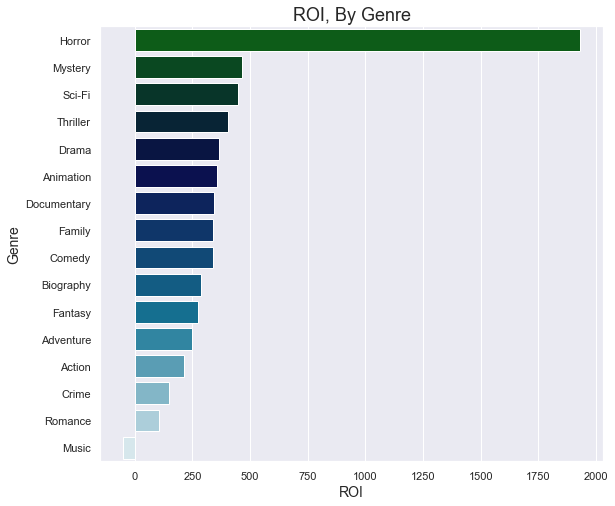

In [262]:
sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('ROI','main_genre' , data = gross_genre_budget, order= gross_genre_budget['main_genre'], palette='ocean');
plot.set_title('ROI, By Genre',fontsize=18);
plt.xlabel('ROI', fontsize=14);
plt.ylabel('Genre', fontsize=14);

## Total Gross Revenue by Genre

This graph represents Gross Revenue categorized by genre. As you can see, Action, Adventure, and Comedy are the top three highest grossing genres.

In [263]:
# Displaying relevant data, group by genre, sum total_gross, sort by total gross
gross_genre = gross_genre.groupby(['main_genre'])['total_gross'].sum().reset_index().sort_values('total_gross', ascending=False)

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


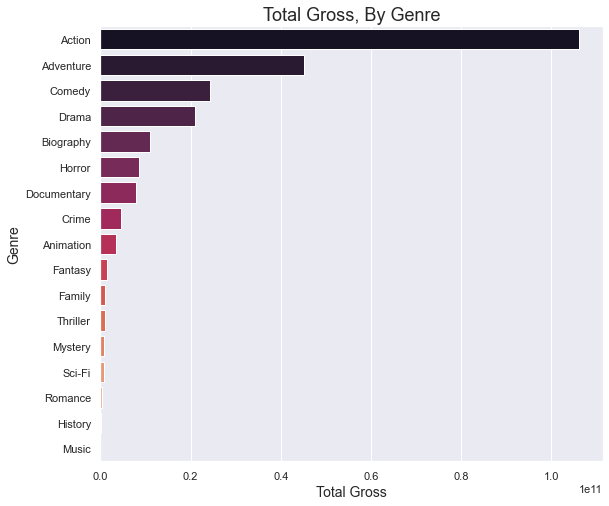

In [264]:
sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('total_gross','main_genre' , data = gross_genre, order= gross_genre['main_genre'], palette='rocket');
plot.set_title('Total Gross, By Genre',fontsize=18);
plt.xlabel('Total Gross', fontsize=14);
plt.ylabel('Genre', fontsize=14);

# Question 1 Conclusion:

The figures show that the genres with the highest ROI are different than the genres with the highest total gross. The genres with the highest ROI are Horror, Mystery, and Sci-Fi. The highest grossing genres are Action, Adventure, and Comedy. Since Microsoft is new to the movie production industry, I would suggest that Microsoft pursue movies with the highest ROI. This is because capital risk would be lower, and potential for return is significantly higher.

# Question 2: What is the run-time and release date (seasonality) associated with the best performing genres?

In this question, I am looking at the run-time and release date (seasonality) for the movies with the highest ROI (Return-On-Investment). If the most successful genres have a certain run-time, then Microsoft should make movies within that time period. Additionally, if the most successful genres tend to release movies during a specific time of the year, then Microsoft should consider the seasonality as well.

## Method:

### Read in Imdb Data

In [265]:
imdb_basics = """
SELECT * 
FROM movie_basics;
"""
imdb_basics = pd.read_sql(imdb_basics, conn)

In [266]:
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [267]:
imdb_basics.dropna(inplace=True)

In [268]:
imdb_basics.drop(['movie_id', 'original_title'], axis=1, inplace=True)

In [269]:
imdb_basics['genres'] = imdb_basics['genres'].str.split(',')
imdb_basics['genre1'] = imdb_basics['genres'].apply(lambda x: x[0])

In [270]:
imdb_basics.head()

,primary_title,start_year,runtime_minutes,genres,genre1
0,Sunghursh,2013,175.0,"[Action, Crime, Drama]",Action
1,One Day Before the Rainy Season,2019,114.0,"[Biography, Drama]",Biography
2,The Other Side of the Wind,2018,122.0,[Drama],Drama
4,The Wandering Soap Opera,2017,80.0,"[Comedy, Drama, Fantasy]",Comedy
5,A Thin Life,2018,75.0,[Comedy],Comedy


In [271]:
# Calculating average runtime per genre
imdb_basics = imdb_basics.groupby('genre1')['runtime_minutes'].mean()

In [272]:
imdb_basics.sort_values(ascending=False)

genre1
Game-Show      130.000000
Romance        105.680995
Musical        100.726562
Action         100.019729
Music           97.272936
Mystery         96.285276
Drama           95.666232
Reality-TV      95.225806
Talk-Show       94.769231
War             94.639344
Comedy          94.315771
Crime           93.019005
Thriller        92.675298
Family          90.507752
Western         89.792079
Fantasy         89.397833
Adult           88.833333
History         88.052632
Sci-Fi          87.308411
Horror          86.441898
Sport           85.023810
Adventure       82.817111
Animation       76.448252
Biography       73.662348
Documentary     73.400817
News            72.500000
Short           16.000000
Name: runtime_minutes, dtype: float64

### Merging Avg. Runtime and ROI Tables

In [273]:
# Inspecting the relevant data sets
imdb_basics = imdb_basics.apply(pd.Series)
imdb_basics.columns = ['runtime_minutes']
imdb_basics.head(3)

,runtime_minutes
genre1,
Action,100.019729
Adult,88.833333
Adventure,82.817111


In [274]:
# resetting index to properly merge
imdb_basics.reset_index(inplace=True)

In [275]:
gross_genre_budget.head(3)

,main_genre,production_budget,worldwide_gross,ROI
0,Horror,1.953194e+07,1.127250e+08,1929.23625
1,Mystery,4.325000e+07,2.103140e+08,467.01250
2,Sci-Fi,1.500000e+08,8.211334e+08,447.42000


In [276]:
# Merging tables on genre
runtime_roi = imdb_basics.merge(gross_genre_budget, how='left', left_on='genre1', right_on='main_genre' )

In [283]:
# Sorting values by ROI to see genres/avg runtime
runtime_roi = runtime_roi.sort_values(by = 'runtime_minutes', ascending=False)

In [284]:
# Dropping missing values
runtime_roi.dropna(inplace=True)

In [285]:
runtime_roi = runtime_roi.loc[:,['genre1','runtime_minutes','ROI']]

In [286]:
runtime_roi

,genre1,runtime_minutes,ROI
19,Romance,105.680995,107.303333
0,Action,100.019729,214.105331
14,Music,97.272936,-49.540000
16,Mystery,96.285276,467.012500
8,Drama,95.666232,365.784286
5,Comedy,94.315771,340.015409
6,Crime,93.019005,150.004412
24,Thriller,92.675298,402.268182
9,Family,90.507752,341.295000
10,Fantasy,89.397833,276.044000


/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


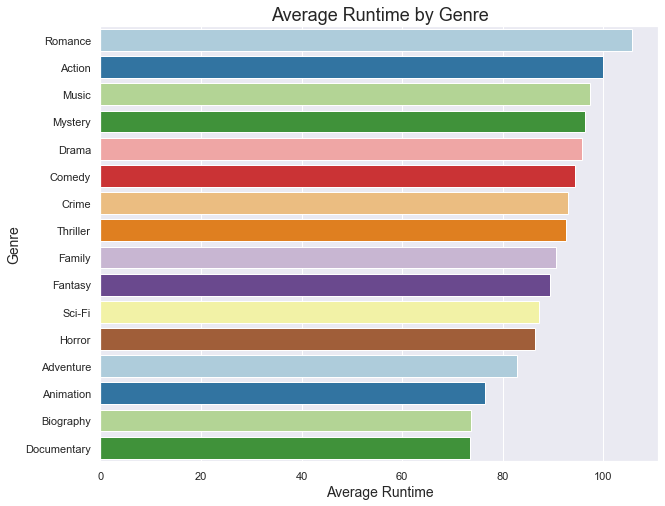

In [287]:
# create horizontal barplot using seaborn
# Format Plot
sns.set(rc={'figure.figsize':(10,8)})
plot = sns.barplot('runtime_minutes','genre1' , data = runtime_roi, order= runtime_roi['genre1'], palette='Paired');

# Set Labels
plot.set_title('Average Runtime by Genre', fontsize=18);
plt.xlabel('Average Runtime', fontsize=14);
plt.ylabel('Genre', fontsize=14);